In [1]:
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np

In [2]:
menu_items = pd.read_csv("MenuItem.csv")
menu_pages = pd.read_csv("MenuPage.csv")
menus = pd.read_csv("Menu.csv")
dishes = pd.read_csv("Dish.csv")

In [3]:
LUXURY = ["caviar", "foie", "truffle", "lobster", "turtle", "pate", "mumm", "champagne", "quenelle", "duxelle"]
STAPLE = ["soup", "gumbo", "rice", "potato", "apple", "banana", "onion", "beef", "milk", "oats"]
CPI_RAW = {1890: 9.1, 1900: 8.4, 1910: 9.5, 1920: 20.0, 1930: 17.1, 1940: 14.0}
z = 60  # minimum count for each categories

In [4]:
menu_items = menu_items.merge(dishes[['id', 'name']], left_on='dish_id', right_on='id', suffixes=('', '_dish'))
menu_items = menu_items.merge(menu_pages[['id', 'menu_id']], left_on='menu_page_id', right_on='id', suffixes=('', '_page'))
menu_items = menu_items.merge(menus[['id', 'date']], left_on='menu_id', right_on='id', suffixes=('', '_menu'))
menu_items = menu_items.merge(menus[["id", "currency"]], left_on="menu_id", right_on="id", suffixes=('', '_menu_currency'))

#change to year
menu_items["year_extracted"] = pd.to_datetime(menu_items["date"], errors='coerce').dt.year.astype("Int64")
#remove rows missing data
menu_items = menu_items.dropna(subset=["price", "year_extracted", "name"])

In [5]:
print("Rows kept before USD-only filter:", len(menu_items))

Rows kept before USD-only filter: 837813


In [6]:
#only keep USD
menu_items = menu_items[menu_items["currency"].isin(["Dollars", "Cents"])].copy()

#covert cents to dollars
menu_items.loc[menu_items["currency"] == "Cents", "price"] = (
    menu_items.loc[menu_items["currency"] == "Cents", "price"] / 100.0
)

# use dollards
menu_items.loc[menu_items["currency"] == "Cents", "currency"] = "Dollars"

#  sanity check
print("Rows kept after USD-only filter:", len(menu_items))

Rows kept after USD-only filter: 777959


In [7]:
#create categories
def categorize(name):
    
    name = str(name).lower()
    
    for kw in LUXURY:
        if kw in name:
            return "luxury"
    for kw in STAPLE:
        if kw in name:
            return "staple"
    return "unknown"

menu_items["category"] = menu_items["name"].apply(categorize)
menu_items = menu_items[menu_items["category"].isin(["luxury", "staple"])]
print(menu_items['category'].value_counts())  # see count luxury vs. staple

category
staple    107865
luxury     24881
Name: count, dtype: int64


In [8]:
#Adjust for inflation 
years = np.array(list(CPI_RAW.keys()))
cpi_vals = np.array(list(CPI_RAW.values()))

#func to extrapolate in between year values 
cpi_func = interp1d(years, cpi_vals, kind='linear', fill_value='extrapolate')

menu_items["cpi"] = menu_items["year_extracted"].apply(lambda y: cpi_func(y))
menu_items["real_price"] = menu_items["price"] / menu_items["cpi"] * 100

In [9]:
counts = (menu_items.groupby("year_extracted")["category"].value_counts().unstack().fillna(0).astype(int))
print(counts)

category        luxury  staple
year_extracted                
1851                 7       0
1852                17       1
1855                 1       0
1856                14       0
1857                 7       0
...                ...     ...
2004                 0       5
2005                 5       2
2006                 5       6
2008                15       9
2012                11      18

[130 rows x 2 columns]


In [10]:
valid_years = counts[
    (counts["luxury"] >= z) & (counts["staple"] >= z)
].index

menu_items_filtered = menu_items[menu_items["year_extracted"].isin(valid_years)]

filtered_counts = counts.loc[valid_years]
filtered_counts = filtered_counts[(filtered_counts.index >= 1890) & (filtered_counts.index <= 1940)]

print(filtered_counts)

category        luxury  staple
year_extracted                
1892               121     437
1893                65      95
1896               114     206
1898                75     192
1899               137     448
1900              3929   13417
1901              1364    4770
1905               402    1285
1906               666    2160
1907               413    1800
1912               439    1272
1913              1132    6666
1914              2715   12682
1915               431    2036
1916               158     686
1917              2497   12724
1918              2508    7853
1919               216    1072
1920               196     900
1933              1517   10374
1937                65     624
1938               153     784
1939               198    1100
1940               274    1634


In [11]:
price_by_year = (
    menu_items_filtered
    .groupby(["year_extracted", "category"])["real_price"]
    .mean()
    .unstack()
)

price_by_year["premium"] = price_by_year["luxury"] - price_by_year["staple"]
price_by_year = price_by_year[(price_by_year.index >= 1890) & (price_by_year.index <= 1940)]
price_by_year = price_by_year.dropna()
print(price_by_year)

category           luxury    staple    premium
year_extracted                                
1892             9.025421  3.774722   5.250698
1893            14.787575  4.132378  10.655196
1896            13.304430  5.732406   7.572025
1898            15.807963  3.887954  11.920009
1899            11.362559  3.900320   7.462239
1900            14.709138  5.258822   9.450315
1901            15.577413  5.167631  10.409782
1905            10.121182  3.950873   6.170309
1906            11.578466  5.866190   5.712275
1907            26.268678  7.144978  19.123700
1912            13.854960  4.506479   9.348481
1913            16.989064  7.702693   9.286371
1914             9.482303  3.178106   6.304197
1915             6.332140  2.086977   4.245164
1916             8.491428  1.648799   6.842629
1917             8.909873  3.003227   5.906646
1918            10.256141  2.761148   7.494993
1919             7.646829  2.131985   5.514844
1920            11.780612  2.905000   8.875612
1933         

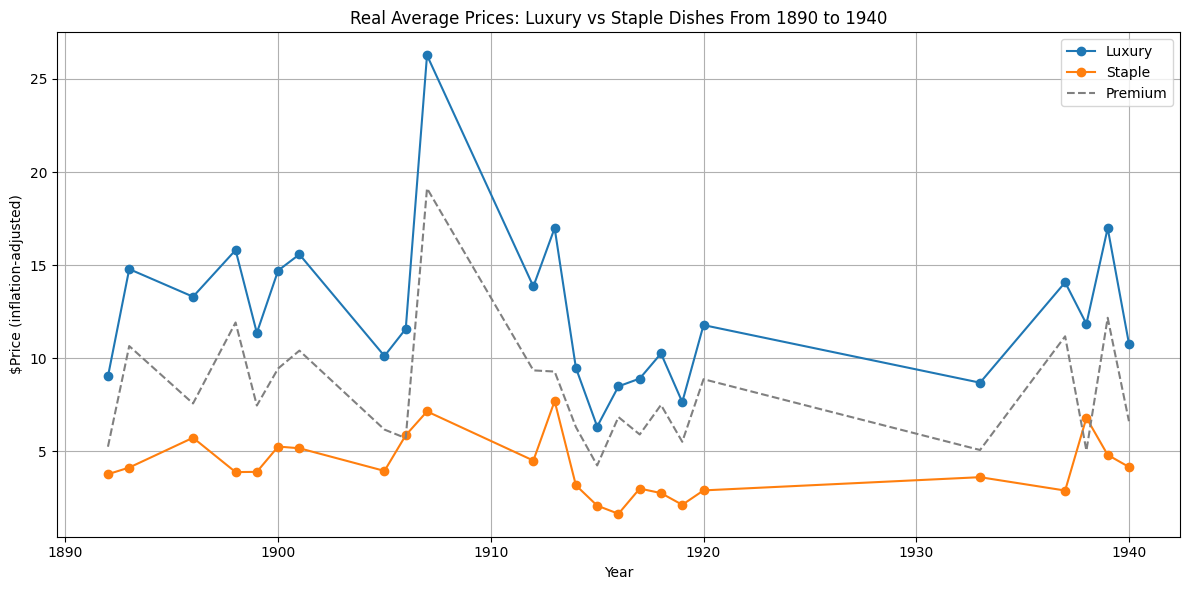

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(price_by_year.index, price_by_year["luxury"], label="Luxury", marker='o')
plt.plot(price_by_year.index, price_by_year["staple"], label="Staple", marker='o')
plt.plot(price_by_year.index, price_by_year["premium"], label="Premium", linestyle='--', color='gray')

plt.title("Real Average Prices: Luxury vs Staple Dishes From 1890 to 1940")
plt.xlabel("Year")
plt.ylabel("$Price (inflation-adjusted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()